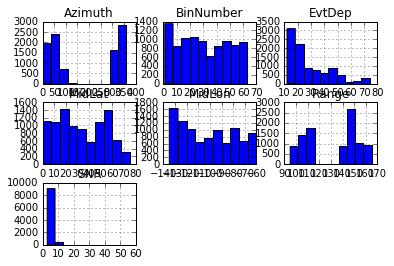

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
conn = sqlite3.connect("ss.db")
cur  = conn.cursor()

import time
import os

import pandas as pd

qry = """SELECT
bin_contents.BinNumber,
bin_contents.ID_Full,
bouncepoints_full.Event,
bouncepoints_full.Range,
bouncepoints_full.EvtDep,
bouncepoints_full.EvtTime,
bouncepoints_full.Azimuth,
bouncepoints_full.MidLat,
bouncepoints_full.MidLon,
snr.SNR
FROM bin_contents
LEFT JOIN bouncepoints_full 
ON bouncepoints_full.ID_Full=bin_contents.ID_Full
LEFT JOIN snr
ON bouncepoints_full.ID_Full=snr.ID_Full
WHERE bouncepoints_full.EvtDep < 75
AND ((bouncepoints_full.Range > 95
AND bouncepoints_full.Range < 115)
OR (bouncepoints_full.Range > 140
AND bouncepoints_full.Range < 165))
AND snr.SNR >= 3.0
ORDER BY bouncepoints_full.EvtDep
"""

dfds = pd.read_sql_query(qry, conn)

%matplotlib inline
dfbins = pd.read_sql_query("SELECT * from bin_parameters", conn)
_ = dfds.hist()

In [5]:
from matplotlib import pylab as plt
%matplotlib inline

def plot_location(bin_number, df=[]):

    binparams = dfbins.query('index == %d' % bin_number)

    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap


    # Lambert Conformal Conic map.
    m = Basemap(llcrnrlon=-135.,llcrnrlat=-10.,urcrnrlon=45.,urcrnrlat=61.,
                projection='lcc',lat_1=35.,lat_2=45.,lon_0=-100.,
                resolution ='l',area_thresh=1000.)
    names = []

    # draw coastlines, meridians and parallels.
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='#99ffff')
    m.fillcontinents(color='#cc9966',lake_color='#99ffff')
    m.drawparallels(np.arange(10,71,20),labels=[1,1,0,0])
    m.drawmeridians(np.arange(-180,0,20),labels=[0,0,0,1])

    x, y = m( np.array(binparams.Longitude), np.array(binparams.Latitude) )

    m.scatter(x, y, color='black', marker = 'o', s=1000, zorder = 10000)
    
    if len(df) != 0:
        x, y = m( np.array(df['MidLon']), np.array(df['MidLat']) )
        m.scatter(x, y, color='red', marker = '.', zorder = 10000)

    plt.title('Bin Location')

plt.style.use('ggplot')

In [6]:
import pickle
file=open('migrator.pickle','rb')
f = pickle.load(file)
file.close()

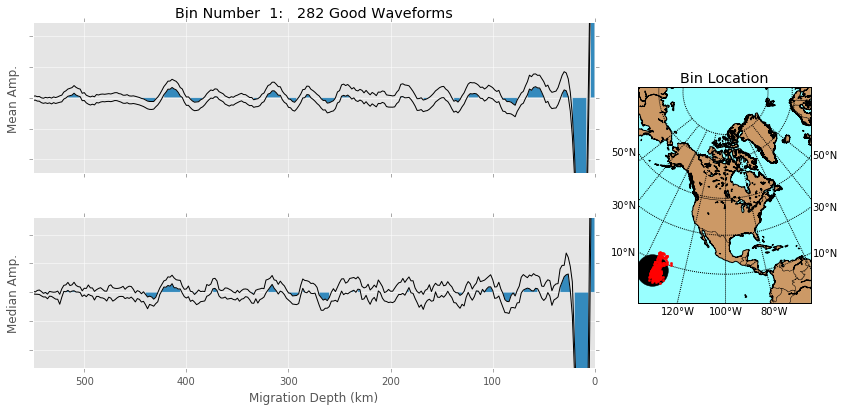

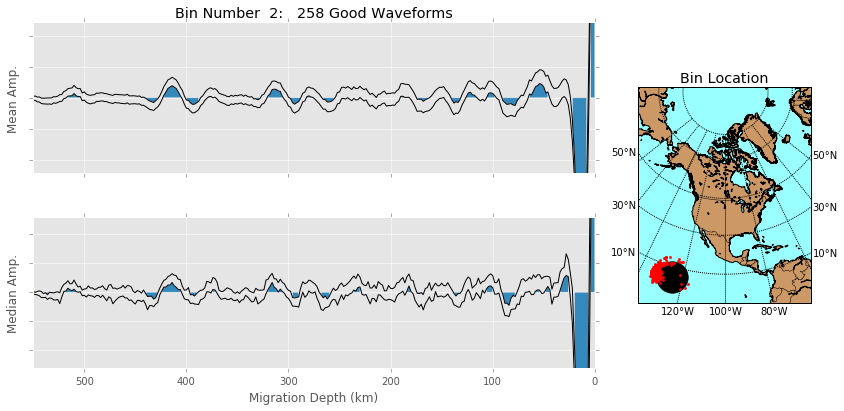

Skipping bin   3


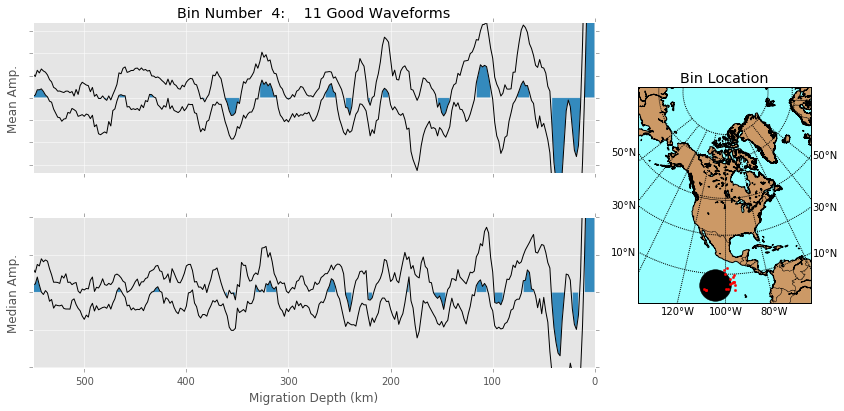

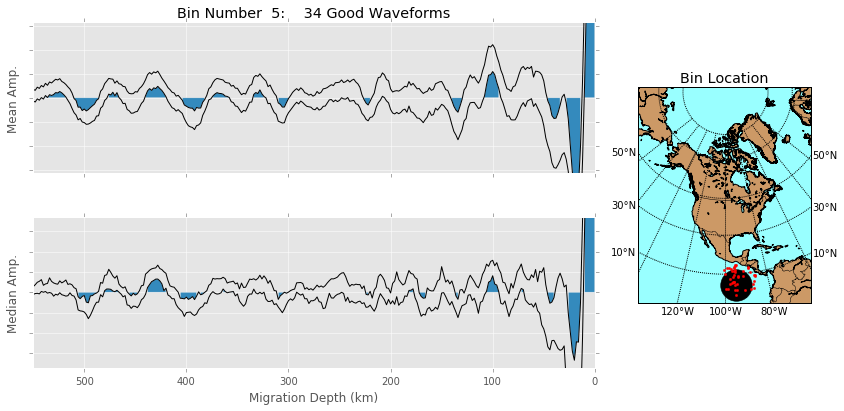

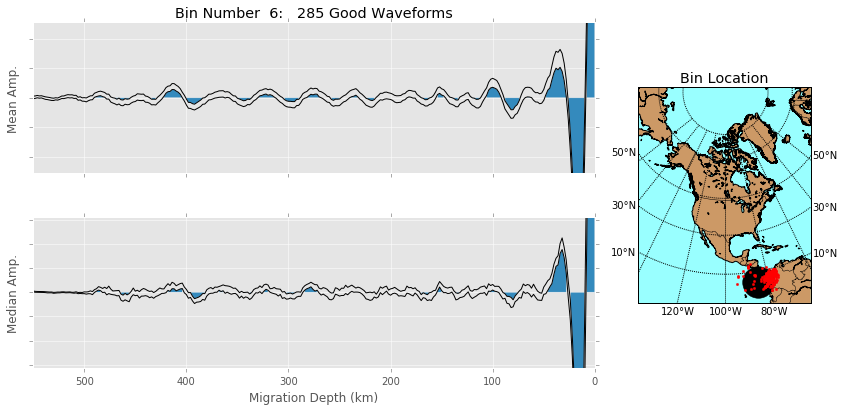

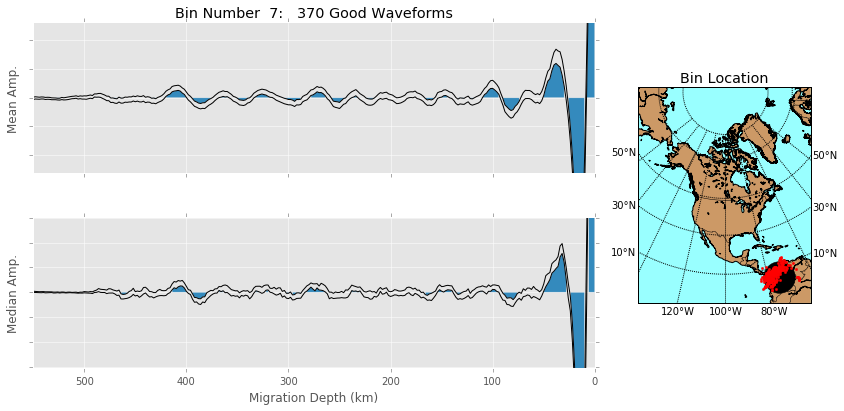

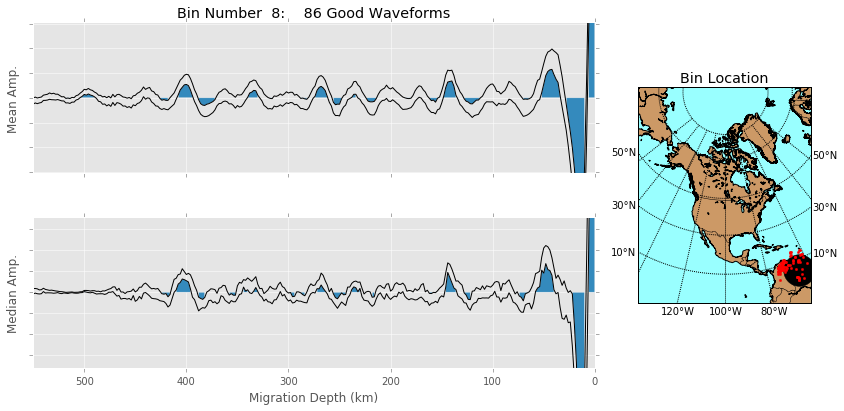

Skipping bin   9


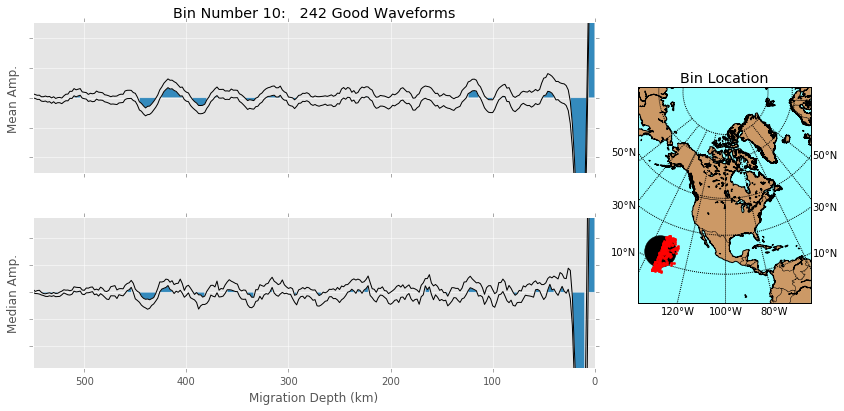

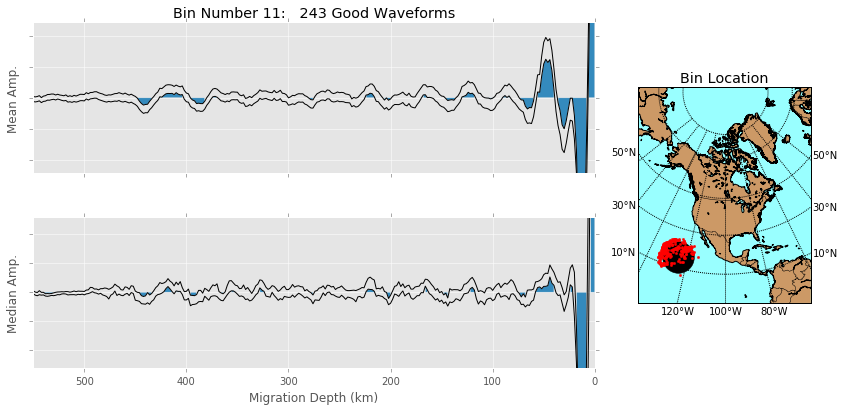

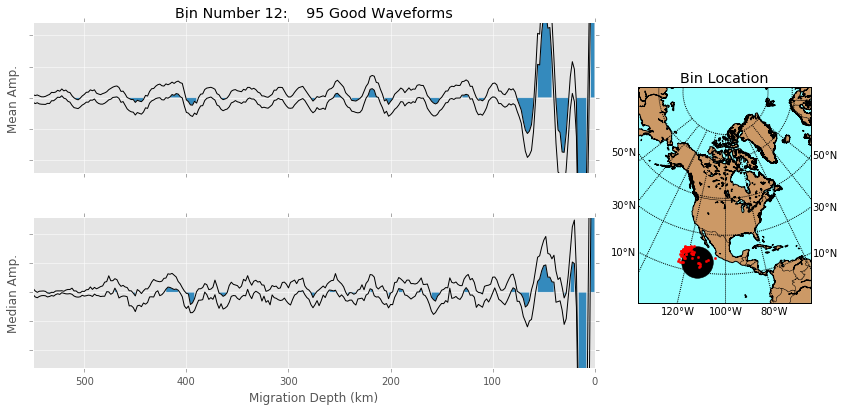

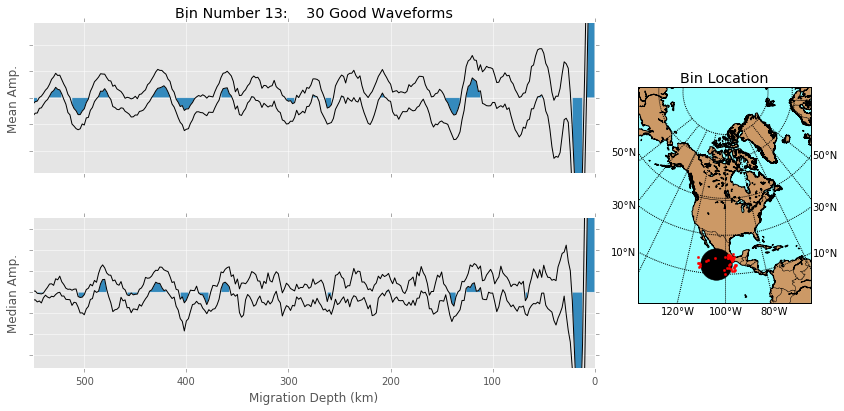

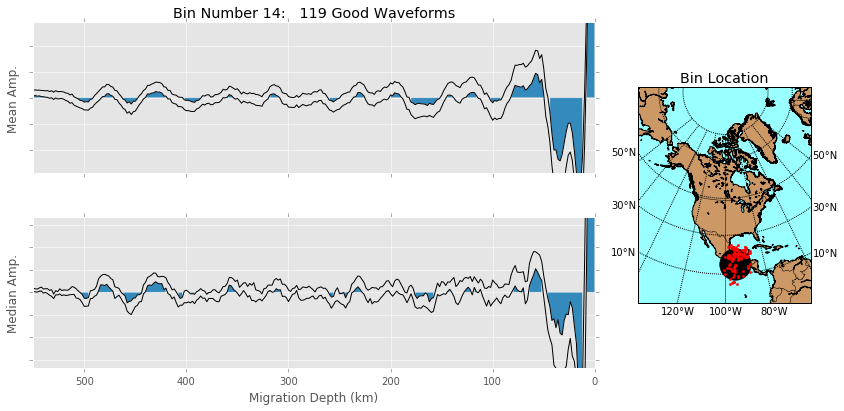

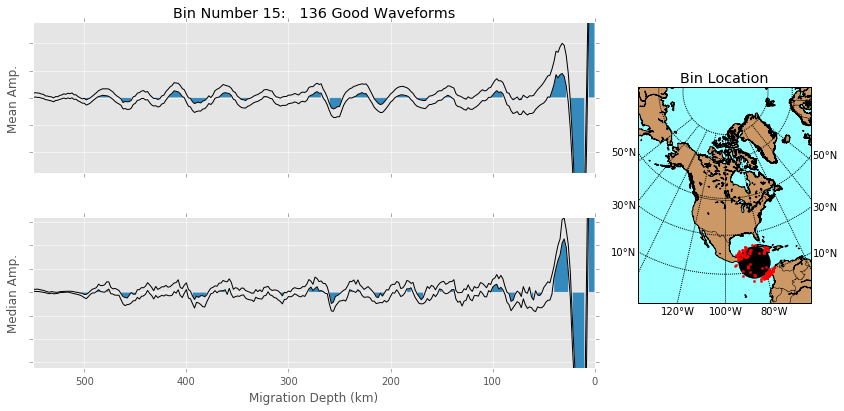

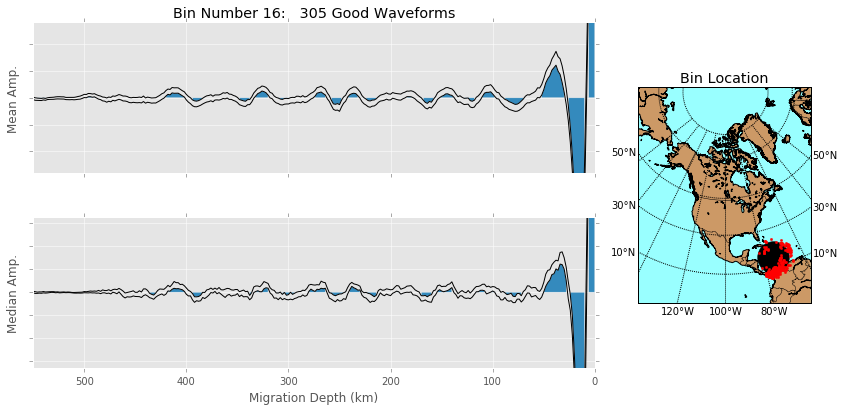

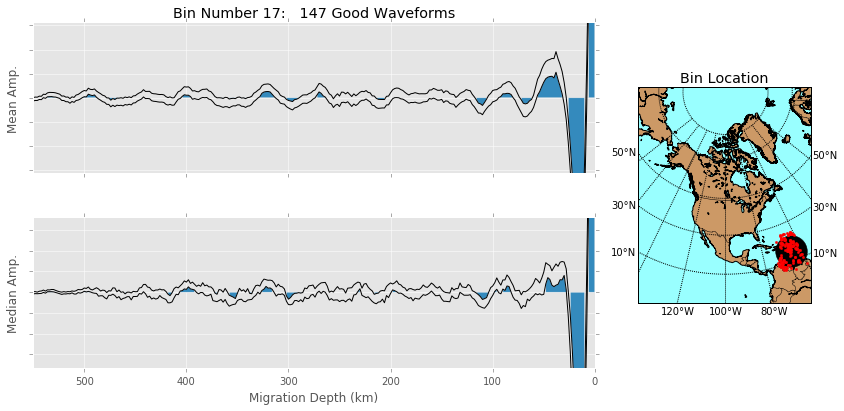

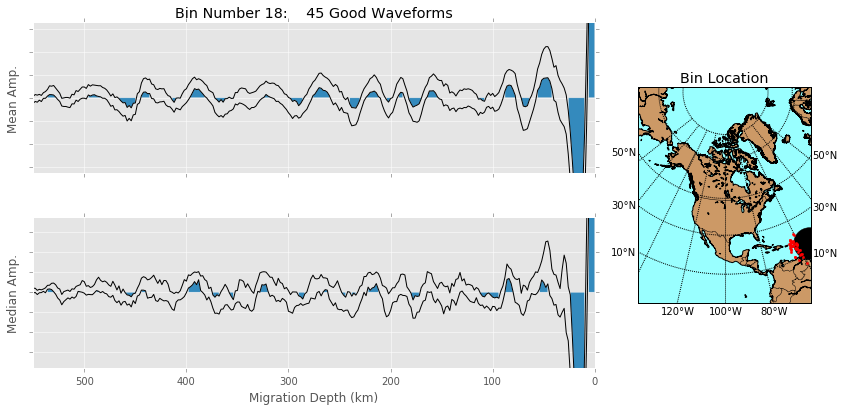

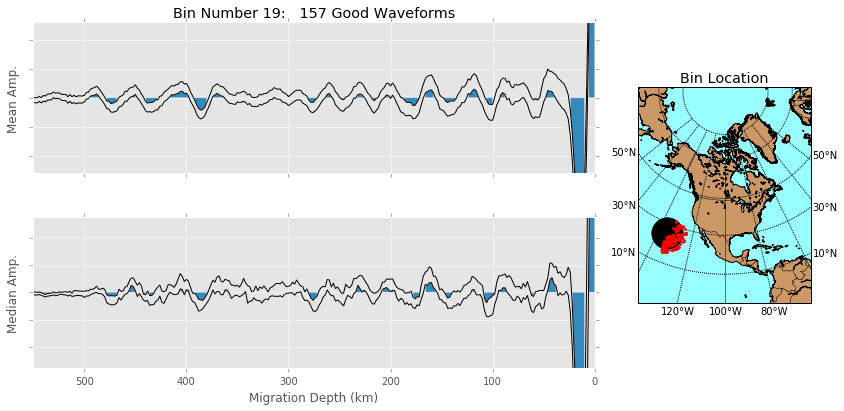

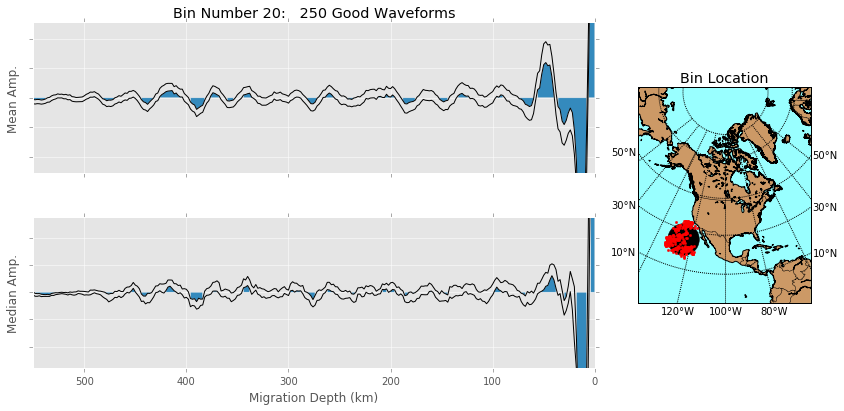

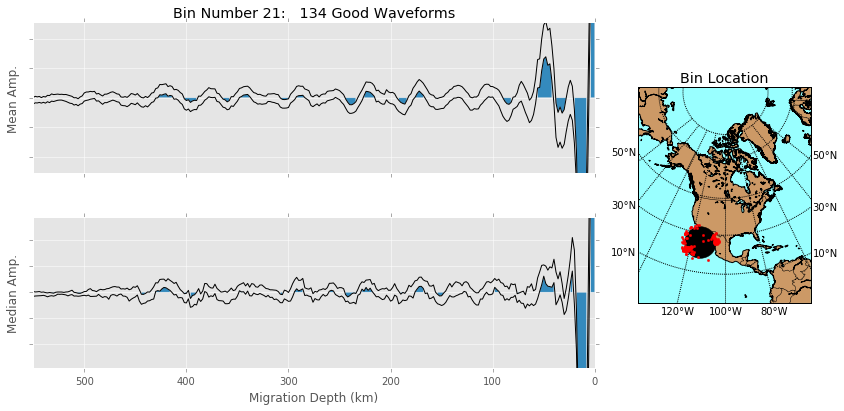

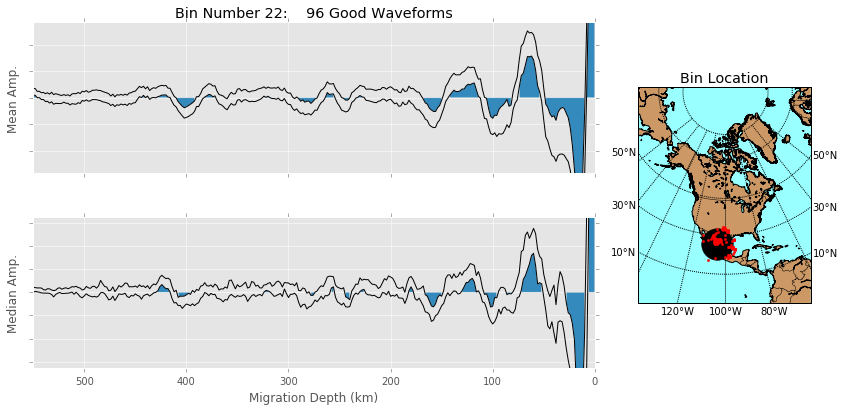

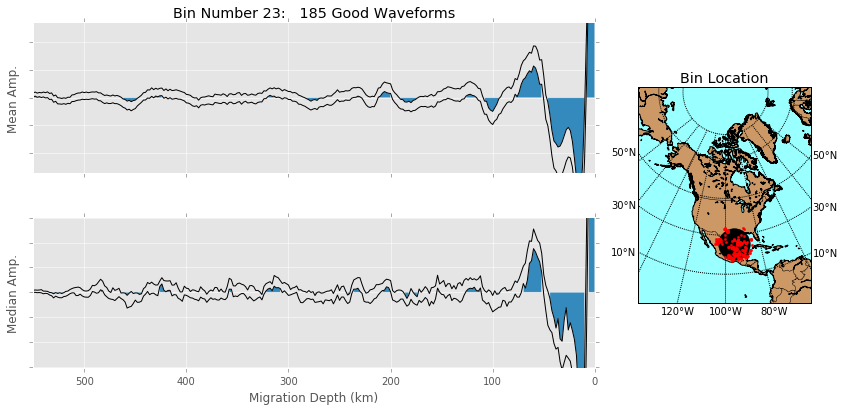

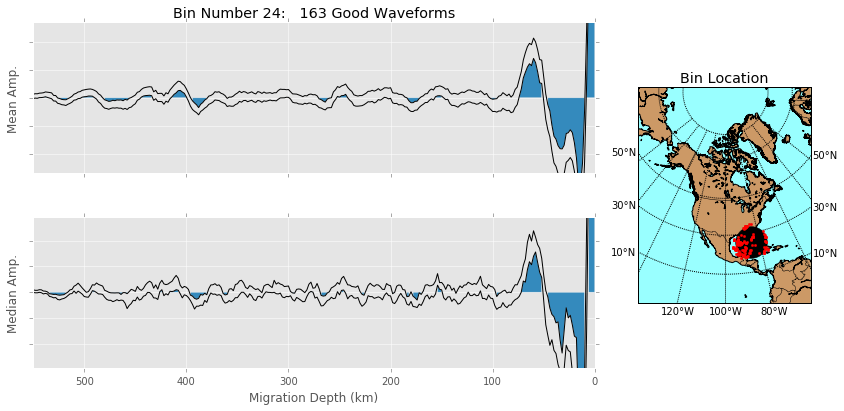

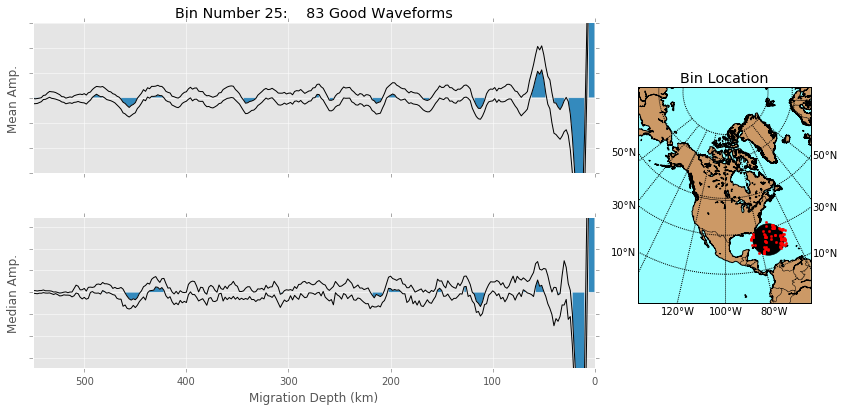

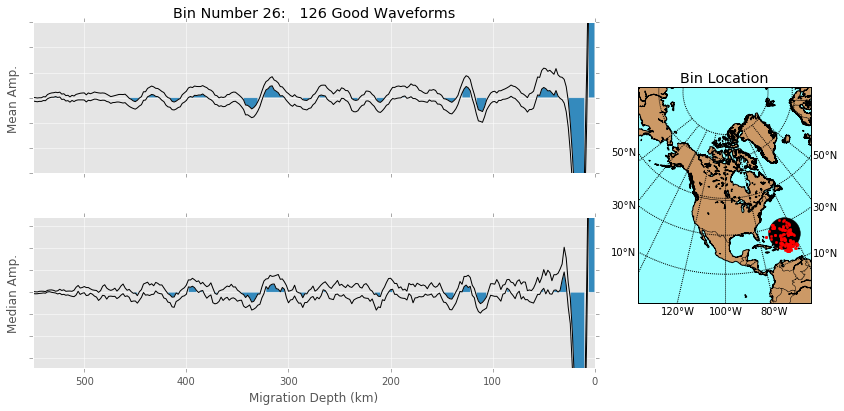

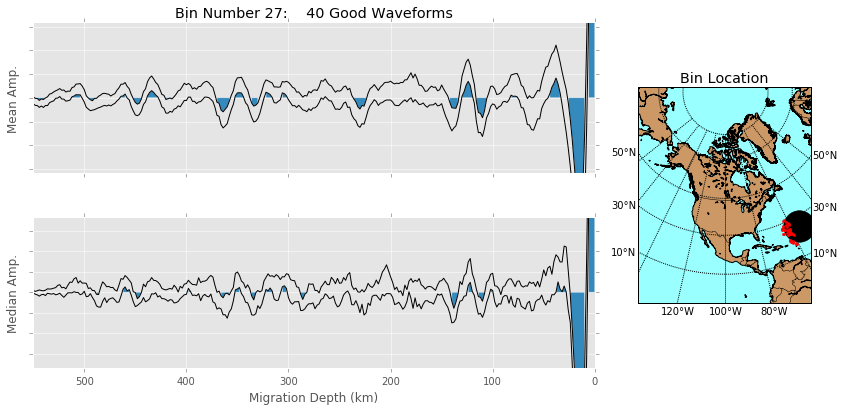

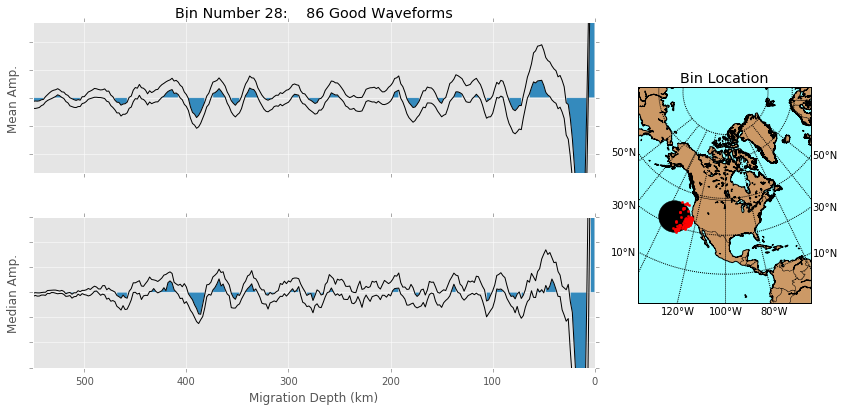

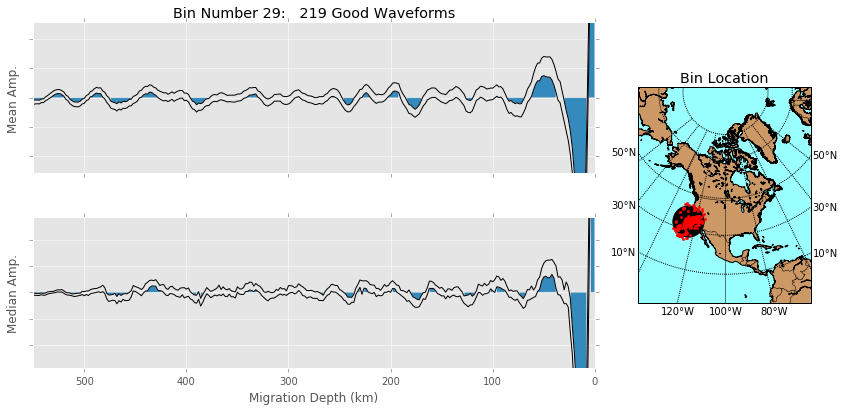

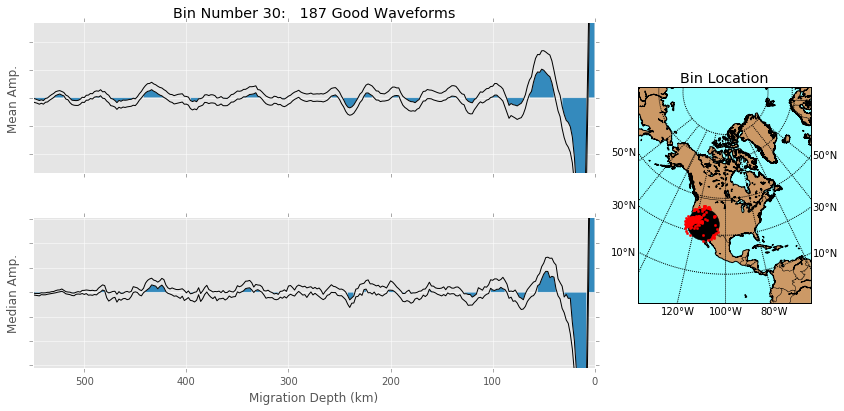

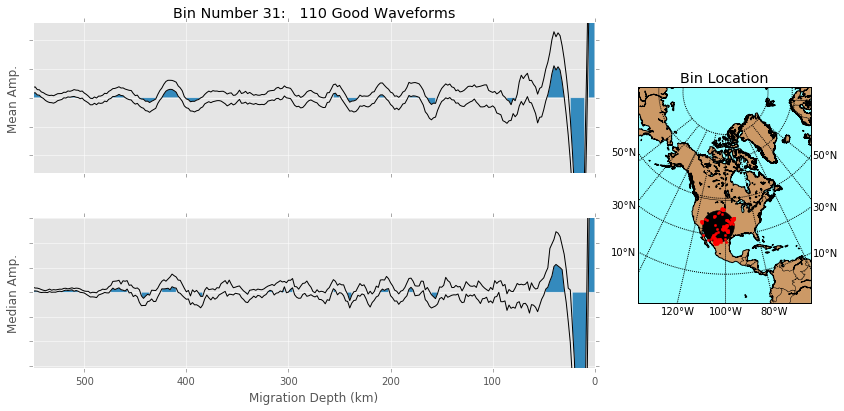

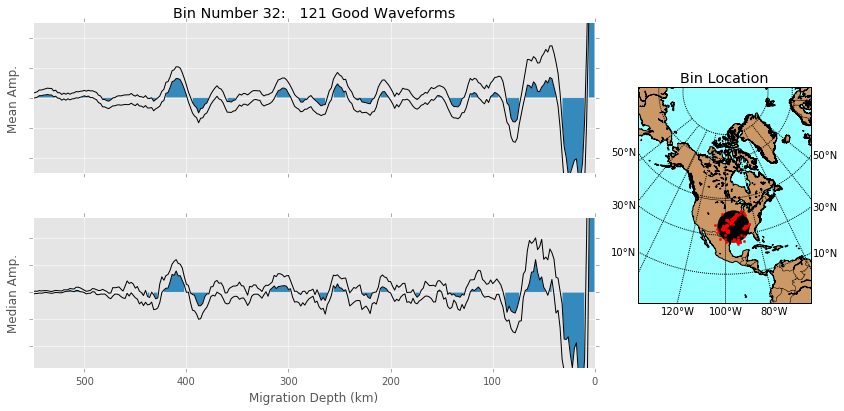

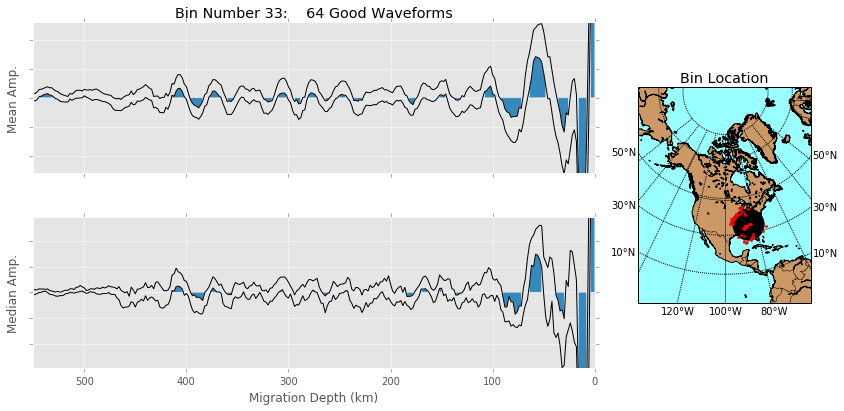

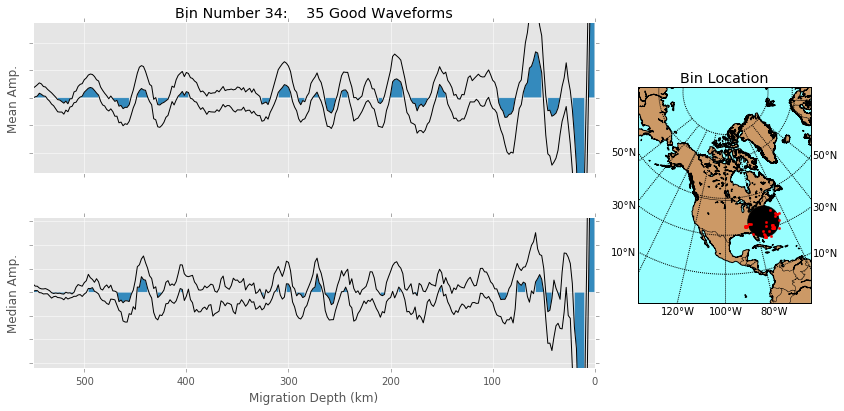

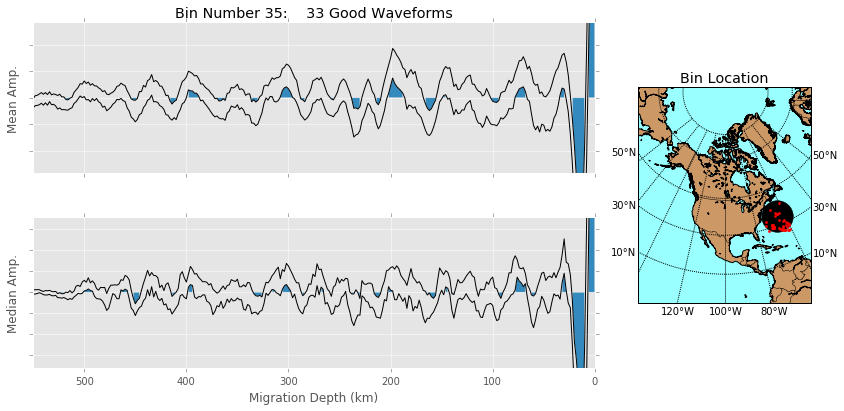

Skipping bin  36


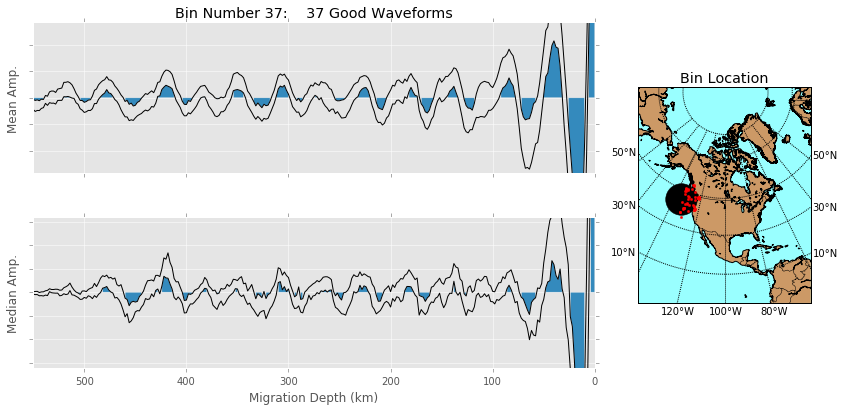

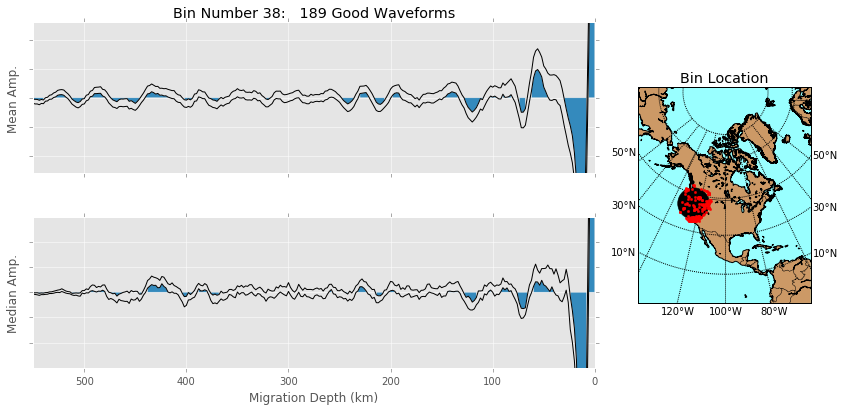

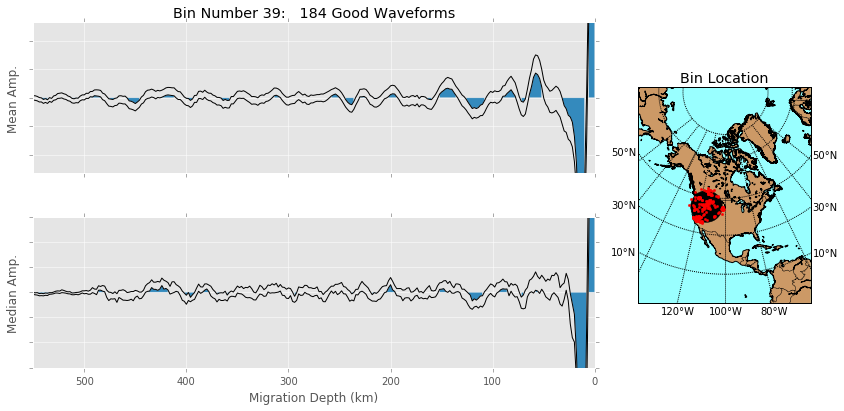

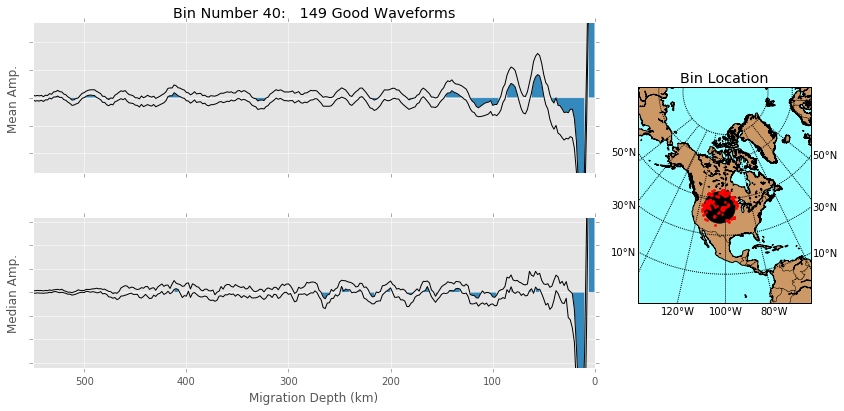

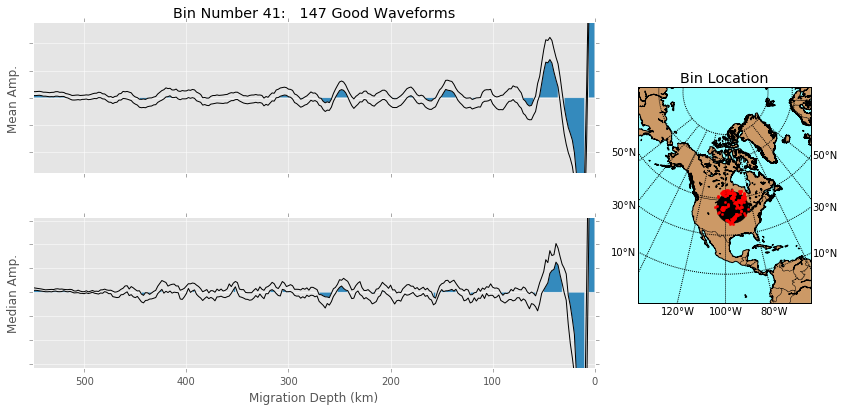

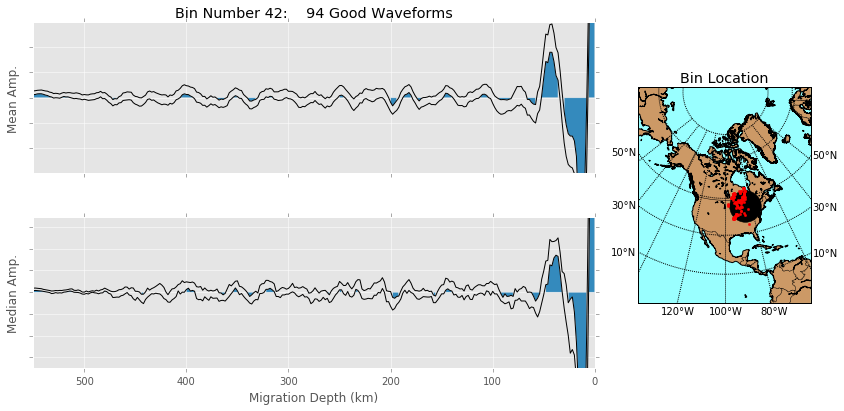

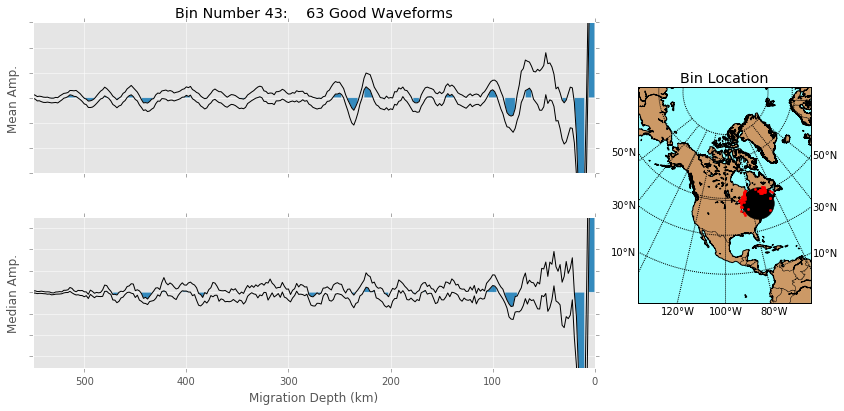

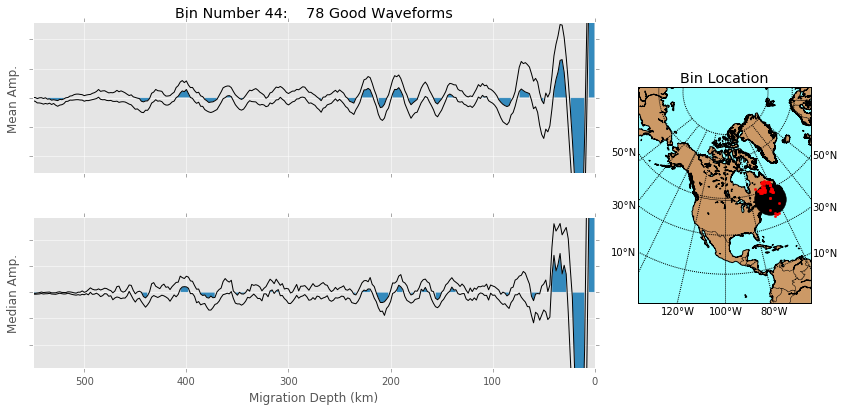

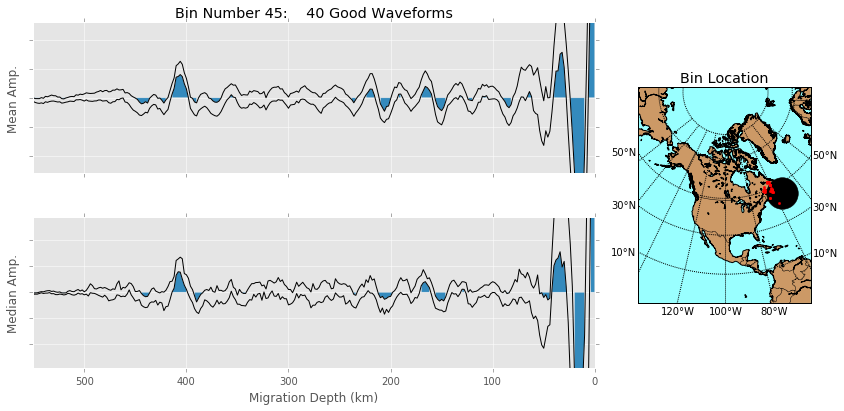

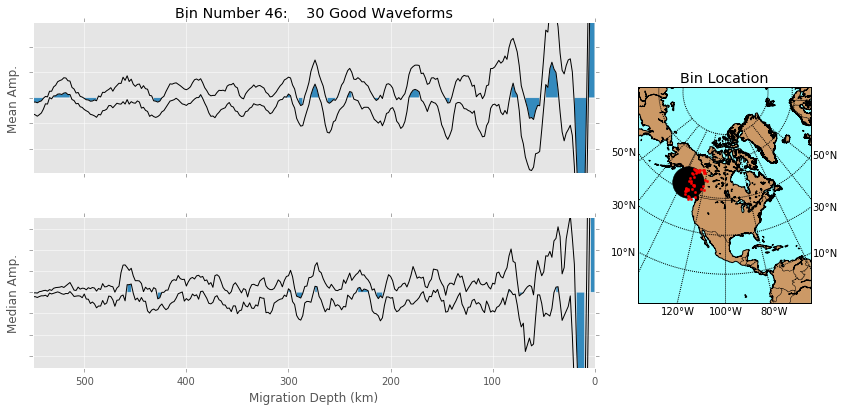

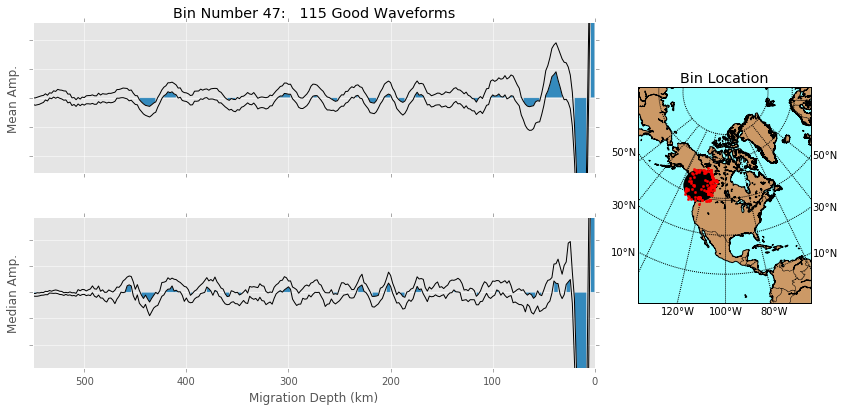

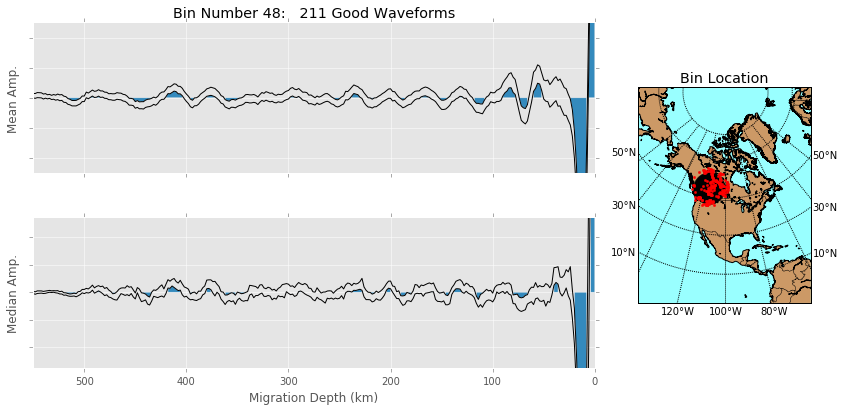

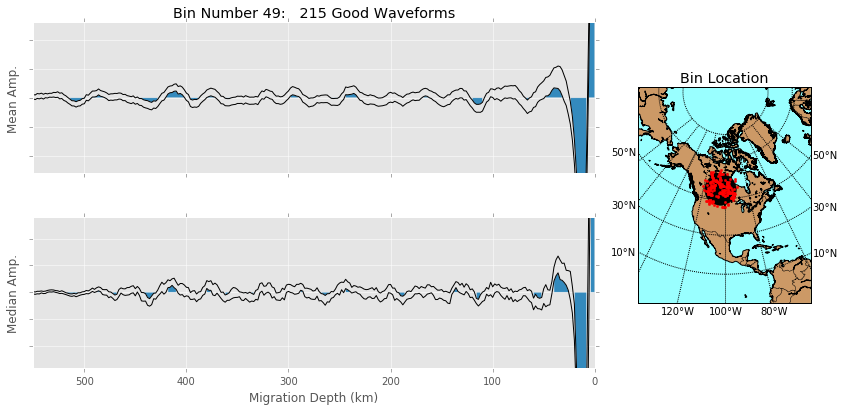

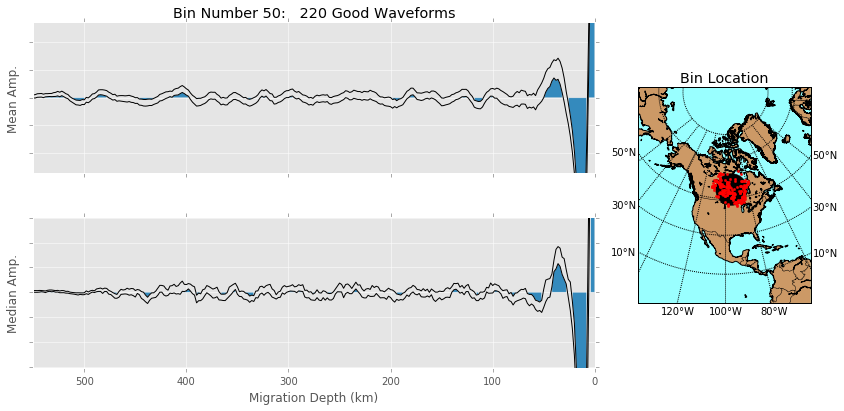

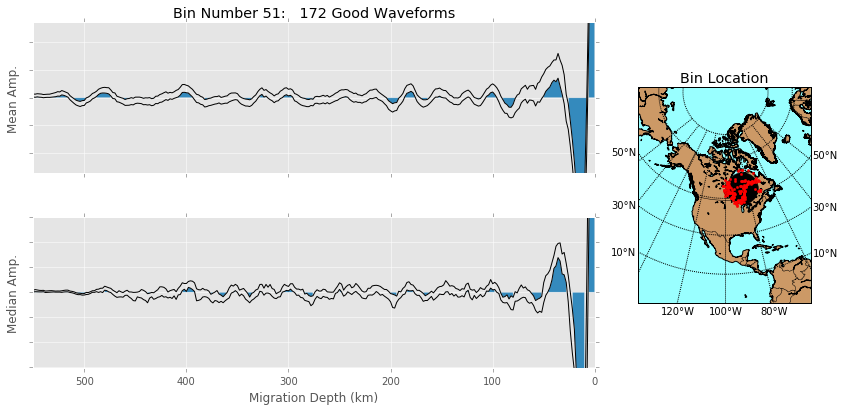

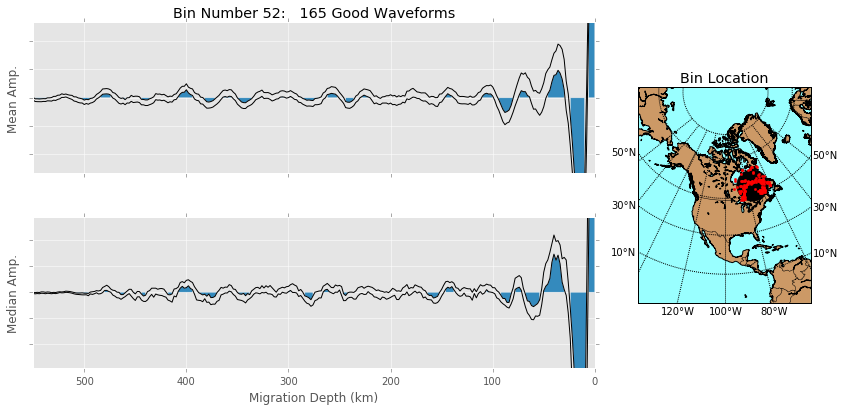

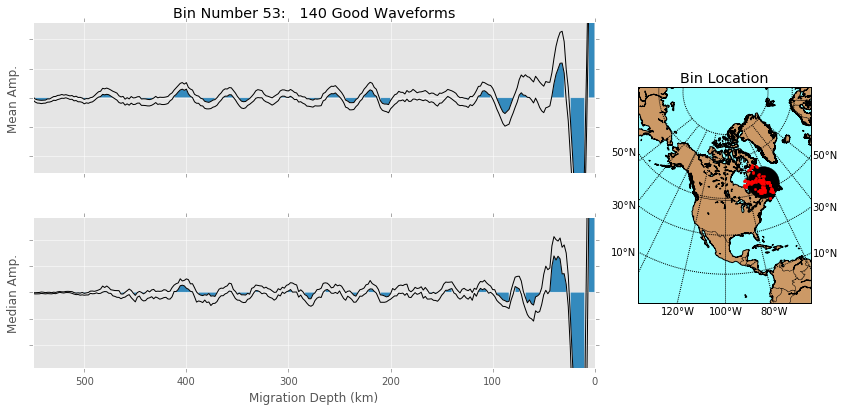

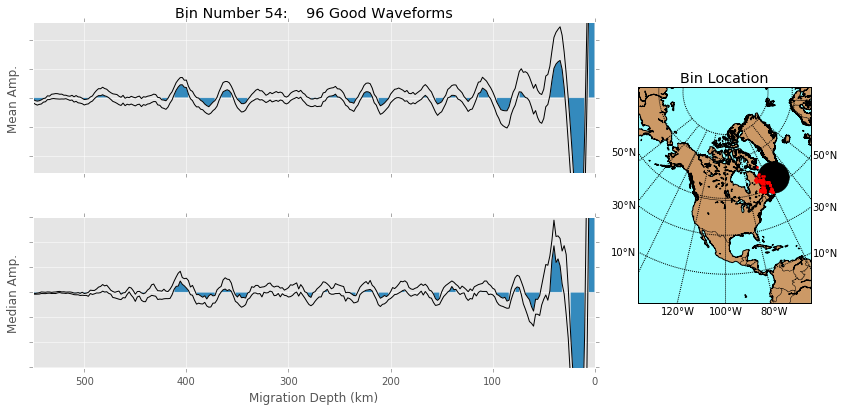

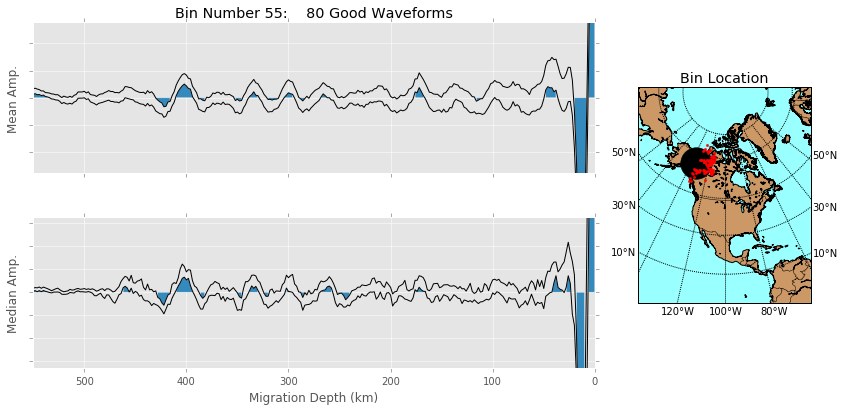

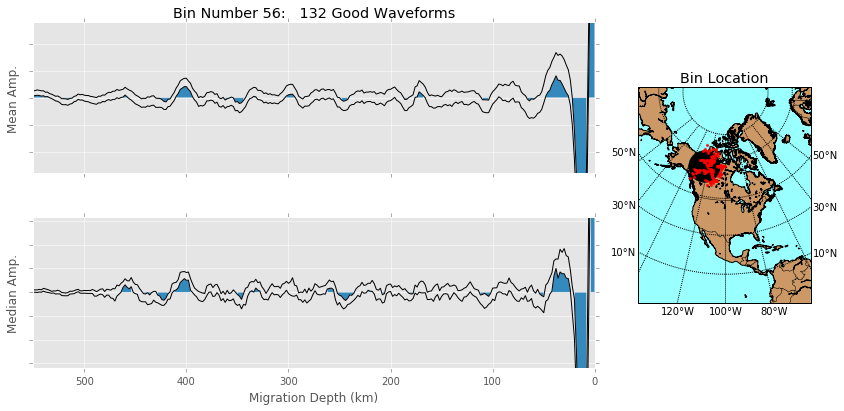

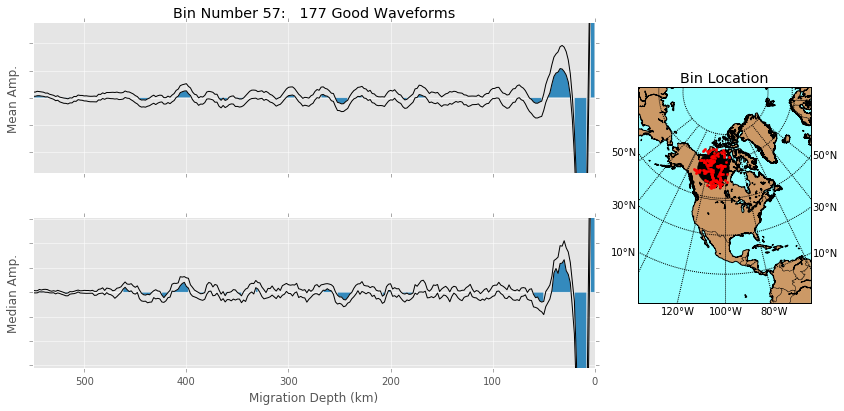

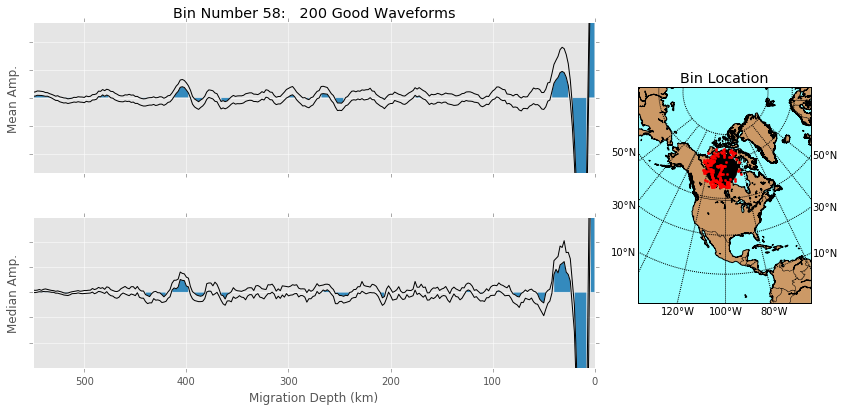

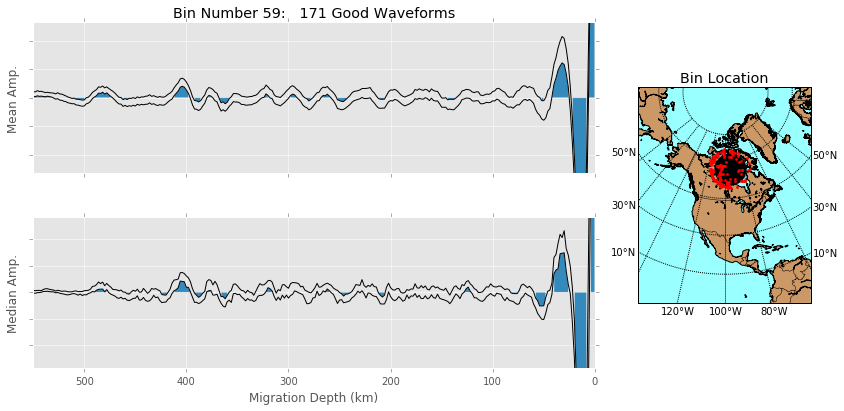

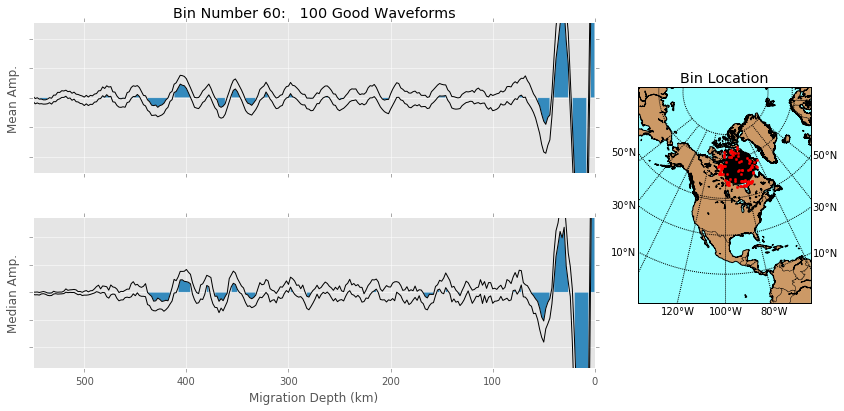

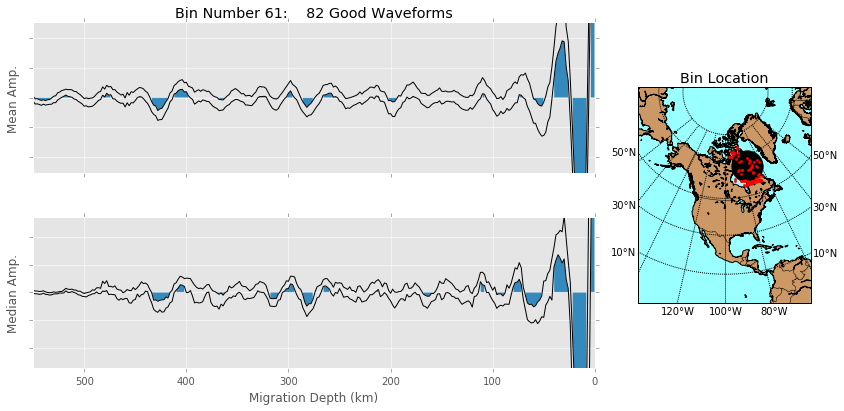

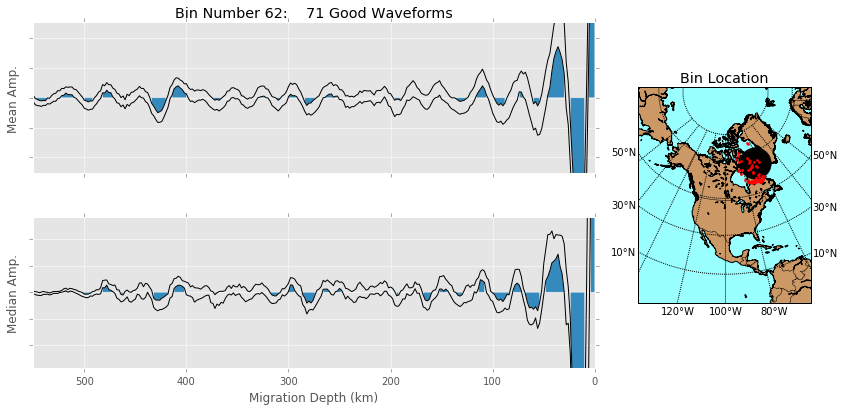

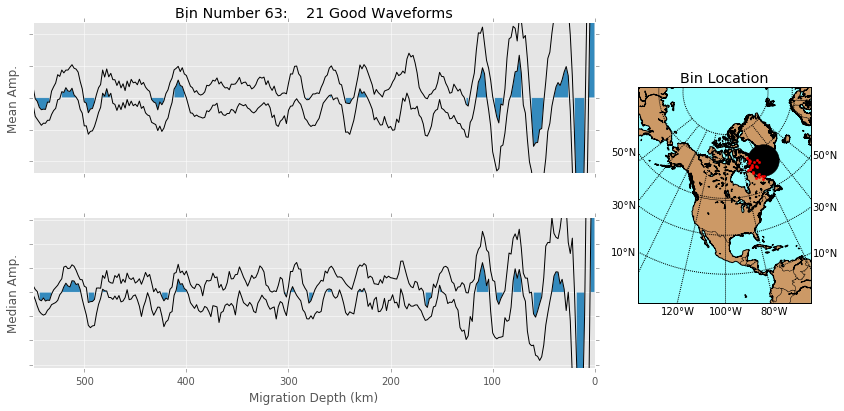

In [13]:
import obspy
from matplotlib import pylab as plt
from numpy import zeros, argmax, nan, sign, arange
from obspy.signal.filter import envelope
from scipy.signal import hilbert

from numpy import nanmean, nanmedian, nanstd, nanmin, nanmax
from numpy.random import choice

from ss_precursors import Stack

for bin_number in sorted(dfds.BinNumber.unique()):
    dfbin = dfds.query("BinNumber == %d" % bin_number)
    #dfbin.Range.hist()
    plt.show()

    st = obspy.Stream()
    
    depths = range(0,552,2)
    
    npts = 800
    
    ndeps = len(depths)
    
    
    ngood = 0
    
    shifts = {}
    quality = {}

    rbin = zeros(ndeps*len(dfbin)).reshape(ndeps,len(dfbin)) + nan

    for ii, row in enumerate(dfbin.iterrows()):
        bpindex = row[1].ID_Full
        directory = 'data/mseed/%s/' % row[1].Event
        filename = directory + bpindex + '.mseed'
        st0 = obspy.read(filename).detrend('linear').taper(0.05)
        #st0.filter('bandpass',freqmin=0.01,freqmax=0.1,corners=4)
        #st0.filter('lowpass',freq=0.05,corners=4,zerophase=False)
        st0.filter('bandpass',freqmax=1./10., freqmin=1./50., corners=4,zerophase=False)
        tr = st0[0]
        tr.data = hilbert(tr.data).imag
        imax = argmax(abs(envelope(tr.data)))
        norm = sign(tr.data[imax])*envelope(tr.data)[imax]
        if imax < 195 or imax > 240:
            shifts[bpindex]  =  imax
            quality[bpindex] = 'bad'
            continue
        else:
            shifts[bpindex]  =  imax
            quality[bpindex] = 'good'
            ngood += 1
        
        tlist = f(row[1].Range,depths)
        ilist = []
        for each in tlist:
            tmp = int(each) + imax
            if tmp >= 0:
                pass
            else:
                tmp = 0
            ilist.append(tmp)
        tmp        = tr.data/norm  
        #tmp        = hilbert(-tr.data).imag/norm  #This is Nick Schmerr's way
        rbin[:,ii] = tmp[ilist]

    #plt.imshow(rbin,aspect='auto',origin='lower')
    #plt.colorbar()
    #plt.show()
    
    if ngood < 10:
        print('Skipping bin %3d' % bin_number)
        continue

    fig = plt.figure(1,figsize=(12,6))


    nboot = 1000
    bbin = zeros(ndeps*nboot*2).reshape(ndeps,nboot,2) + nan

    for iboot in range(nboot):
        random_sample = choice(range(len(dfbin)), size = len(dfbin))
        bbin[:,iboot,0] = nanmean(  rbin[:,random_sample],axis=1)
        bbin[:,iboot,1] = nanmedian(rbin[:,random_sample],axis=1)

    for itype in [0,1]:
        if itype == 1:
            ax = fig.add_axes([0.05, 0.10, 0.65, 0.35])
        else:
            ax = fig.add_axes([0.05, 0.55, 0.65, 0.35])
        
        #ax = plt.subplot(2,1,itype+1)
        
        #plt.fill([-60,-60,-20,-20], [-2,2,2,-2], 'r', alpha=0.2, edgecolor='k')
        #plt.fill([-175,-175,-140,-140], [-2,2,2,-2], 'b', alpha=0.2, edgecolor='k')
        #plt.fill([-100,-100,-70,-70], [-2,2,2,-2], 'b', alpha=0.2, edgecolor='k')
        
        fmean=nanmean(bbin[:,:,itype],axis=1)
        fstd=nanstd(bbin[:,:,itype],axis=1)
        
        fmin=fmean-1.*fstd
        fmax=fmean+1.*fstd

        times = arange(len(fmin))*tr.stats.delta-npts/2
        
        #
        stack = Stack()
        stack.depths = depths
        stack.amplitude = fmean
        stack.standard_error = fstd
        stack.metadata = {"ngood": ngood, "bin_number": bin_number, "itype": itype}
        stack.save("data/stacks/stack_bin_%d_type_%d.pickle" % (bin_number, itype) )

        #plt.plot(nanmean(bbin,axis=1))
        plt.plot(depths,fmax,'k')
        plt.plot(depths,fmin,'k')
        plt.fill_between(depths,0,fmin, where=fmin>0)
        plt.fill_between(depths,fmax,0, where=fmax<0)

        zoom_factor = 5.
        buf=1.04/zoom_factor

        plt.ylim(-nanmax(fmax)*buf,nanmax(fmax)*buf)
        plt.xlim(550,0)
        plt.gca().set_yticklabels([])
        
        if itype == 0:
            plt.title('Bin Number %2d: %5d Good Waveforms' % (bin_number, ngood))
            plt.gca().set_xticklabels([])
            plt.ylabel('Mean Amp.')
        else:
            plt.xlabel('Migration Depth (km)')
            plt.ylabel('Median Amp.')
            #plt.text(0.15,1.06,'410', transform=ax.transAxes)
            #plt.text(0.42,1.06,'Lehmann', transform=ax.transAxes)
            #plt.text(0.58,1.06,'LAB/MLD', transform=ax.transAxes)
            #for discon in discons.keys():
            #    time = discons[discon]
            #    plt.text(time,nanmax(fmax)*buf*1.07,'%s' % discon, weight='bold')
                
        
    
    ## Output QC results
    tmp1 = pd.DataFrame(shifts, index=["Shift"]).T
    tmp2 = pd.DataFrame(quality, index=["Quality"]).T
    tmp1.join(tmp2)

    table_name = 'qcbin%d' % bin_number
    tmp1.join(tmp2).to_sql(table_name,conn, if_exists="replace", index_label="ID_Full")
    
    
    #ax = fig.add_axes([0.95, 0.15, 0.5, 0.7])
    ax = fig.add_axes([0.75, 0.05, 0.20, 0.90])
    
    plot_location(bin_number, dfbin)
    
    plt.savefig('img/bin_%d.eps' % bin_number)
    